# Creating a TPF and LCF

In this tutorial, we will learn the basics of `tess_asteroids` by creating a TPF and LCF for a couple of asteriods.

In [1]:
from tess_asteroids.utils import target_observability
from tess_asteroids import MovingTPF
import matplotlib.pyplot as plt
import numpy as np

## Main-belt asteroid 1980 VR1

Let's start with main-belt asteroid 1980 VR1.

### Was my target observed by TESS?

Firstly, we need to know if TESS observed this target and, if so, in what observing sector/camera/CCD. We can use the utils functions `target_observability` to find out. This might take a couple of minutes to run as it's checking all available TESS sectors.

In [2]:
target_observability("1980 VR1")

{'sector': [1, 1, 68],
 'camera': [1, 1, 1],
 'ccd': [2, 1, 2],
 'dur': [2.0, 20.0, 25.0]}

Looks like our target was observed by TESS in sectors 1 (camera 1, CCD 1 & 2) and 68 (camera 1, CCD 2). Great, now we can create a TPF and LCF for that data!

### Creating a TPF

We can only create a TPF for one sector/camera/CCD at a time. Let's use sector 1, camera 1, CCD 1 as an example. 

Initialising `MovingTPF` with `from_name()` will query the JPL/Horizons database for the target's ephemeris during that sector. The `make_tpf()` function will then retrieve the relevant pixel data, perform a background correction and define the target aperture.

In [3]:
# Initialise MovingTPF for asteroid 1980 VR1 in TESS sector 1, camera 1, CCD 1
target = MovingTPF.from_name("1980 VR1", sector=1, camera=1, ccd=1)

# Make TPF (if we wanted to save this as a .fits file, we would set save=True)
target.make_tpf()

Warning from TESSSpacecraft(): {message : ErfaWarning('ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"'), category : 'ErfaWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/erfa/core.py', lineno : 133, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
100%|███████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:17<00:00, 54.61it/s]


We can visualise the TPF by using the `animate_tpf()` function:

In [4]:
# Animate TPF (if we wanted to save this as a .gif file, we would set save=True)
target.animate_tpf()

### Understanding the contents of the TPF

The `make_tpf()` function creates an HDUList containing all of the TPF data. If we had set `save=True`, then this would have been written to a file. 

The header of the "PRIMARY" HDU contains information about how the file was created, the observation and the target. Some of the keywords have been included for consistency with the SPOC TPFs (e.g. TICID, TEFF, LOGG, RADIUS...), but they are not relevant for an asteroid.

In [5]:
target.tpf_hdulist["PRIMARY"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'STScI/MAST'         / institution responsible for creating this file 
SPOCDATE= '2021-05-11'         / original SPOC FFI creation date                
SPOCVER = 'spoc-5.0.12-20200925' / SPOC version that processed FFI data         
DATE    = '2025-06-05'         / file creation date.                            
TSTART  =   1331.0161538387586 / observation start time in BTJD of first frame  
TSTOP   =   1352.3909265609716 / observation start time in BTJD of last frame   
DATE-OBS= '2018-07-31T12:22:06.508' / TSTART as UTC calendar date               
DATE-END= '2018-08-21T21:21:

The "PIXELS" HDU contains a table with the same columns as a SPOC TPF. Note: FLUX is the background corrected flux and QUALITY corresponds to the SPOC-assigned quality flags.

In [6]:
target.tpf_hdulist["PIXELS"].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'I'
    name = 'RAW_CNTS'; format = '121I'; unit = 'e-/s'; disp = 'I8'; dim = '(11, 11)'
    name = 'FLUX'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11, 11)'
    name = 'FLUX_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11, 11)'
    name = 'FLUX_BKG'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11, 11)'
    name = 'FLUX_BKG_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11, 11)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

The target aperture changes as a function of time. The "APERTURE" HDU contains the average aperture across all time. We can plot that as follows:

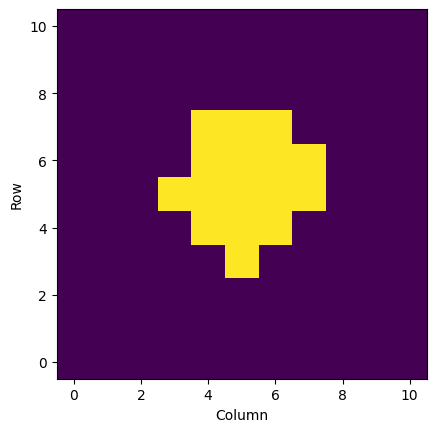

In [7]:
plt.imshow(target.tpf_hdulist["APERTURE"].data, origin="lower")
plt.xlabel("Column")
plt.ylabel("Row");

Finally, the "EXTRAS" HDU is a table containing columns not found in a SPOC TPF. For example:
- ORIGINAL_TIME is the original timestamp from the TESS FFI data. This timestamp is not accurate. TIME from the "PIXELS" HDU is more accurate and is the recommended value.
- CORNER1/CORNER2 are the original FFI column/row of the lower-left pixel in the TPF.
- PIXEL_QUALITY is defined by `tess_asteroids` to identify pixels that could have quality issues e.g. saturation
- APERTURE is the aperture as a function of time.

In [8]:
target.tpf_hdulist["EXTRAS"].columns

ColDefs(
    name = 'ORIGINAL_TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'ORIGINAL_TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'RA_PRED'; format = 'E'; unit = 'deg'; disp = 'E14.7'
    name = 'DEC_PRED'; format = 'E'; unit = 'deg'; disp = 'E14.7'
    name = 'CORNER1'; format = 'I'; unit = 'pixel'
    name = 'CORNER2'; format = 'I'; unit = 'pixel'
    name = 'PIXEL_QUALITY'; format = '121I'; disp = 'B16.16'; dim = '(11, 11)'
    name = 'APERTURE'; format = '121J'; dim = '(11, 11)'
)

### Creating a LCF

After we've made our TPF, we can extract the lightcurve using aperture photometry.

In [9]:
# Make LC (if we wanted to save this as a .fits file, we would set save=True)
target.make_lc()

Let's plot the lightcurve:

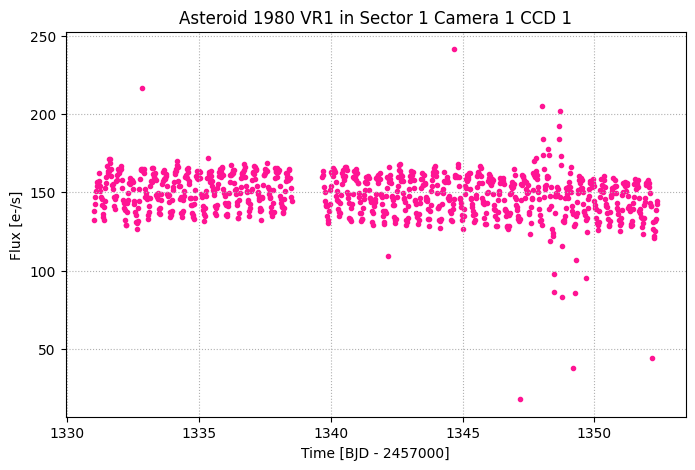

In [10]:
lc = target.lc["aperture"]

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(lc["time"], lc["flux"], color="deeppink", marker=".")
ax.set_xlabel("Time [BJD - 2457000]")
ax.set_ylabel("Flux [e-/s]")
ax.grid(ls=":")
ax.set_title(f"Asteroid {target.target} in Sector {target.sector} Camera {target.camera} CCD {target.ccd}");

We can use the quality flags from SPOC and `tess_asteroids` to mask cadences of lesser quality, and then we can highlight these on our lightcurve plot:

In [11]:
# Define array of bad binary digits from SPOC (as recommended in the TESS archive manual, excluding those not included in FFI data)
bad_spoc_bits = [1,3,5,6,15]
spoc_value = 0
for bit in bad_spoc_bits:
    spoc_value += 2**(bit-1)
    
# Define array of bad binary digits from tess_asteroids (any cadence with non-science or saturated pixels in aperture)
bad_bits = [2,4]
ta_value = 0
for bit in bad_bits:
    ta_value += 2**(bit-1)

# Joint quality mask
quality_mask = np.logical_and(lc["quality"] & ta_value == 0, target.quality & spoc_value == 0)

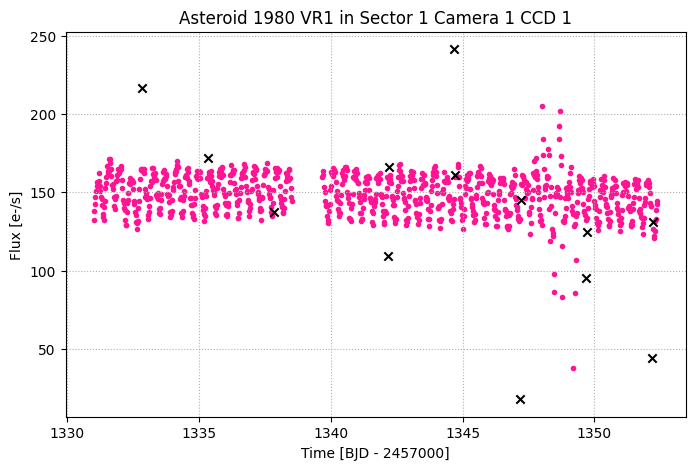

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(lc["time"][quality_mask], lc["flux"][quality_mask], color="deeppink", marker=".")
ax.scatter(lc["time"][~quality_mask], lc["flux"][~quality_mask], color="black", marker="x")
ax.set_xlabel("Time [BJD - 2457000]")
ax.set_ylabel("Flux [e-/s]")
ax.grid(ls=":")
ax.set_title(f"Asteroid {target.target} in Sector {target.sector} Camera {target.camera} CCD {target.ccd}");

### Understanding the contents of the LCF

The `make_lc()` function creates an HDUList containing all of the LC data. If we had set `save=True`, then this would have been written to a file.

The header of the "PRIMARY" HDU contains information about how the file was created and the target. It's very similar to the primary header from the TPF:

In [13]:
target.lc_hdulist["PRIMARY"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'STScI/MAST'         / institution responsible for creating this file 
SPOCDATE= '2021-05-11'         / original SPOC FFI creation date                
SPOCVER = 'spoc-5.0.12-20200925' / SPOC version that processed FFI data         
DATE    = '2025-06-05'         / file creation date.                            
TSTART  =   1331.0161538387586 / observation start time in BTJD of first frame  
TSTOP   =   1352.3909265609716 / observation start time in BTJD of last frame   
DATE-OBS= '2018-07-31T12:22:06.508' / TSTART as UTC calendar date               
DATE-END= '2018-08-21T21:21:

The "LIGHTCURVE" HDU contains all of the data. For example:
- FLUX and FLUX_ERR are created from the TPF using aperture photometry.
- MOM_CENTR1/2 are the measured flux-weighted centroids of the target.
- QUALITY is the original SPOC assigned quality flag.
- AP_QUALITY is defined by `tess_asteroids` to identify cadences that could have quality issues e.g. saturated pixels.

In [14]:
target.lc_hdulist["LIGHTCURVE"].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'ORIGINAL_TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'ORIGINAL_TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'I'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'TESSMAG'; format = 'E'; unit = 'mag'; disp = 'E14.7'
    name = 'TESSMAG_ERR'; format = 'E'; unit = 'mag'; disp = 'E14.7'
    name = 'FLUX_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'FLUX_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR2'; format = 'E'; unit = 'pixel';

## Near-Earth asteroid 2013 OS3

Let's now have a look at near-Earth asteroid 2013 OS3:

In [15]:
target_observability("2013 OS3")

{'sector': [20, 20, 20, 20, 20, 93, 93],
 'camera': [2, 2, 2, 1, 1, 2, 1],
 'ccd': [1, 2, 3, 2, 3, 3, 2],
 'dur': [10.0, 1.0, 6.0, 3.0, 0.0, 4.0, 4.0]}

This asteroid passed through five camera/CCD combinations during sector 20! That's because it moves much faster across the TESS detectors due to its proximity to Earth (and hence TESS). Notice that sector 20, camera 2, CCD 3 has duration of 0.0 days - this just means it was observed for less than a day on this CCD.

In [16]:
# Initialise MovingTPF for asteroid 2013 OS3 in TESS sector 20, camera 2, CCD 3
target = MovingTPF.from_name("2013 OS3", sector=20, camera=2, ccd=3)

# Make TPF
target.make_tpf()

# Animate TPF
target.animate_tpf()

Some of the requested pixels are outside of the FFI science array (1<=row<=2048, 45<=col<=2092), but they will be set to NaN in your TPF.
Warning from TESSSpacecraft(): {message : ErfaWarning('ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"'), category : 'ErfaWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/erfa/core.py', lineno : 133, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Row(s) > 2048)'), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 62, line : None}
The PRF model contained nans in the first frame (cadence number 591). The model was replaced with that from the

Notice that this asteroid has a more elongated shape. Due to the speed with which it moves across the TESS detector, the flux gets smeared along the trail during the long exposures. In a few of the frames, the asteroid reaches the edge of the TPF, so we are probably losing some of the target's flux. That's no problem, we can create a larger TPF to ensure we capture all of the flux! (Note: The first cadence of this TPF is filled with NaN values because these are non-science pixels.)

In [17]:
# Make TPF - larger shape
target.make_tpf(shape=(15,15))

# Animate TPF
target.animate_tpf()

Some of the requested pixels are outside of the FFI science array (1<=row<=2048, 45<=col<=2092), but they will be set to NaN in your TPF.
Warning from TESSSpacecraft(): {message : ErfaWarning('ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"'), category : 'ErfaWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/erfa/core.py', lineno : 133, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Row(s) > 2048)'), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 62, line : None}
The PRF model contained nans in the first frame (cadence number 591). The model was replaced with that from the

That looks better, the target is more comfortably within the bounds of the TPF now.

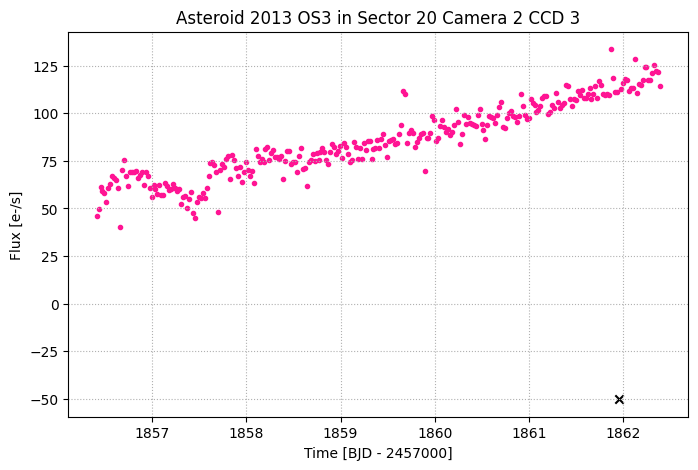

In [18]:
# Make LC
target.make_lc()

lc = target.lc["aperture"]

# Joint quality mask
quality_mask = np.logical_and(lc["quality"] & ta_value == 0, target.quality & spoc_value == 0)

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(lc["time"][quality_mask], lc["flux"][quality_mask], color="deeppink", marker=".")
ax.scatter(lc["time"][~quality_mask], lc["flux"][~quality_mask], color="black", marker="x")
ax.set_xlabel("Time [BJD - 2457000]")
ax.set_ylabel("Flux [e-/s]")
ax.grid(ls=":")
ax.set_title(f"Asteroid {target.target} in Sector {target.sector} Camera {target.camera} CCD {target.ccd}");